# Simulation of Protein-Protein interactions

In [ ]:
### Import all packages needed
import matplotlib.pyplot as plt
import os.path, os
from jinja2 import Template
import ruamel_yaml as yaml
import numpy as np
import json
import pandas as pd
import MDAnalysis as mda
import nglview as nv
%matplotlib inline

### Define the working directory and the Faunus directory
workdir = '/Users/isabelvinterbladh/Documents/YRI-Talk/' # Change to your working directory
faunusdir = '/Users/isabelvinterbladh/Documents/faunus' # Change to your Faunus directory or use faunusdir = os.getcwd() if you are in the Faunus from Conda

### Go to the working directory
%cd -q $workdir



## Faunus - Monte Carlo simulation software

In [ ]:
def makeFaunusInput(outfile, **kwargs):
    ''' generate faunus input file from Jinja2 template '''
    with open('template.yml', 'r') as file: # this is the template file
        template = Template(file.read())
        Cs = kwargs['Cs']
        pH = kwargs['pH']
        dirname = f'Cs{Cs}pH{pH}'
        if not os.path.isdir(dirname):
            os.makedirs(dirname)
        with open(f'Cs{Cs}pH{pH}/' + outfile, 'w') as f:   # open a new faunus input file
            inputstr = template.render(kwargs)
            d = yaml.safe_load(StringIO(inputstr)) # convert string to stream
            f.write(yaml.dump(d))

In [ ]:
salt_conc = 0.05  # Molar
pH = 5.5
steps_eq= 100   
steps_run = 5000
file = '../2hiu.xyz'

%cd -q $workdir
makeFaunusInput('eq.yml', Cs = salt_conc, pH = pH, structure = file, micro = steps_eq)  # equilibration
makeFaunusInput('input.yml', Cs = salt_conc, pH = pH, structure = file, micro = steps_run) # production

In [ ]:
def run_simulation(dir, runeq=True):
    %cd $dir
    if runeq: 
        print('Running equilibration...')
        !yason.py eq.yml | faunus -v6 -o eqout.json > eq.log
    print('Running production...')
    !yason.py input.yml | faunus -v6 -s state.json > run.log

In [ ]:
%cd $workdir
run_simulation('Cs0.05pH5.5', True)

In [ ]:
%cd $workdir/Cs0.05pH5.5
step, q, avg = np.loadtxt('q.dat.gz', unpack=True)
qmin = q.min()
qmax = q.max()
plt.hist(q, bins=20)
plt.xlim(qmin-0.1,qmax+0.1)
plt.xlabel('particle charge')
plt.ylabel('count')
print("average charge = {:.2f} (expecting {:.2f})".format(q.mean(), 0.5*(qmax-qmin)+qmin ))

In [ ]:
R, exact, total, ionion, iondip, dipdip, ionquad, mucorr = np.loadtxt('multipole.dat', unpack=True, skiprows=2)
lw=2
plt.plot(R, ionion, label='ion-ion', lw=lw)
plt.plot(R, iondip, label='ion-dipole', lw=lw)
plt.plot(R, dipdip, label='dipole-dipole', lw=lw)
plt.plot(R, ionquad, label='ion-quadrupole', lw=lw)
plt.plot(R, total, label='sum of multipoles', lw=lw)
plt.plot(R, exact, 'ko', label='exact', ms=2)
plt.xlabel('separation (Å)')
plt.ylabel('energy ($kT/\lambda_B$)')
plt.legend(loc=0, frameon=False)
plt.savefig('multipole.png', bbox_inches='tight')


In [ ]:
mp = {"exact": [], "sum of multipoles": [], "ion-ion": [], "ion-dipole": [], "dipole-dipole": [], "ion-quadrupole": []}


R, exact, tot, ii, id, dd, iq, mucorr = np.loadtxt('multipole.dat', unpack=True, skiprows=2)
rmin = R[np.argmin(exact)]
mask = (R == rmin)
mp['exact'].append( exact[mask] )
mp['sum of multipoles'].append( tot[mask] )
mp['ion-ion'].append( ii[mask] )
mp['ion-dipole'].append( id[mask] )
mp['dipole-dipole'].append( dd[mask] )
mp['ion-quadrupole'].append( iq[mask] )
print(mp)

exact = mp['exact'][0][0]
contributions = {}
sum_of_multipoles = 0
for name, energies in mp.items():
    if name == 'exact' or name == 'sum of multipoles':
        continue
    percentage = np.abs(energies[0][0] / exact) * 100 # use the lowest salt concentration, index 0

In [ ]:
# Load topology and trajectory
u = mda.Universe("confout.xyz", "traj.xtc")

# Show interactive visualization
view = nv.show_mdanalysis(u)

view.animate = True  # Enable animation
view



## Duello - fast calculation of protein interactions

Duello can calculate the potential of mean force (PMF) between two rigid bodies (example protein). This is done by performing a statistical mechanical average over inter-molecular orientations using subdivided icosahedrons. For each mass center separation, R, the static contribution to the partition function is explicitly evaluated to obtain the potential of mean force and the thermally averaged energy. From this the the osmotic second virial coefficient, $B_2$ and for systems with net attractive interactions, the dissociation constant, K d , can be estimated.
More information see: github/mlund/duello (tba)



In [89]:
### Change the following variables to match your system

xyz_file = "2hiu_duello.xyz"   # The name of the xyz file
name = "2hiu"                  # What you want to call the output files 
molarity = "0.1"               # The molarity of the ionic strength in the system
temp = "298"                   # The temperature of the system

resolution = 1.0               # The resolution of the PMF - smaller resolution higher accuracy -> longer runtime
rmin = 5                       # The minimum distance for the PMF - depends on the protein size - approx. protein radius
rmax = 55                      # The maximum distance for the PMF - depends on the protein size
dr = 1.0                       # The distance between each bin in the PMF - smaller dr higher accuracy -> longer runtime

In [90]:
### Command for the duello scan calculation

command = f"/Users/isabelvinterbladh/Documents/YRI-Talk/rust/duello/target/release/duello scan \
-1 {xyz_file} \
-2 {xyz_file} \
--rmin {rmin} --rmax {rmax} --dr {dr} \
--top topology.yaml \
--resolution {resolution}\
--cutoff 1000 \
--molarity {molarity} \
--temperature {temp} \
--pmf {name}-pmf.dat \
&> {name}.log"

# Run the command using the ! syntax
!{command}

print("done.")

done.


In [91]:
### Command to extract values from the duello output

def extract(jsom_file):
    db = dict(B2 = [], B2_HS = [], B2_red = [], kD = [])    
    with open(jsom_file, "r") as file:
        data = json.load(file)
        b2 = data["B2"]
        db["B2"].append(b2)
        b2_hs = data["B2_hs"]
        db["B2_HS"].append(b2_hs)
        b2_reduced = data["B2_reduced"]
        db["B2_red"].append(b2_reduced)
        if "kD" in data:
            db["kD"].append(data["kD"] * 1000)
        else:
            db["kD"].append(float('nan'))
    return pd.DataFrame(db).rename(columns={"kD": "𝐾𝑑/mM", "B2_red": "𝐵₂/𝐵₂hs", "B2_HS": "𝐵₂hs", "B2": "𝐵₂"})

            𝐵₂          𝐵₂hs   𝐵₂/𝐵₂hs      𝐾𝑑/mM
0 -1216.745977  10289.763138 -0.118248  72.156509


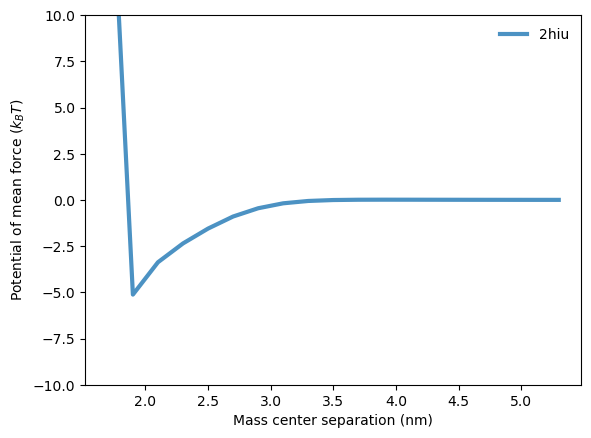

In [92]:
print(extract(f"{name}-pmf.json"))

r, w, u, c = np.loadtxt(f"{name}-pmf.dat", unpack=True)
plt.plot(r/10, u, label=f'{name}', lw=3, alpha=0.8)
#plt.plot(r/10, np.cumsum(c * np.exp(-w) * (r/10)**2), lw=3, alpha=0.8)
plt.legend(loc=0, frameon=False)

plt.ylim(-10, 10)
plt.xlabel("Mass center separation (nm)")
plt.ylabel("Potential of mean force ($k_BT$)")
plt.show()